
# Poisson problem

Let us solve the Poisson problem of finding $u$ satisfying 

$$
\begin{aligned}
-\Delta u + u& = f && \text { in  } (0,10)^2,
\\
\frac{\partial u }{\partial n } & = 0 
&& \text{ on the boundary parts}.
\end{aligned}
$$

## Quick steps to solution:

#### 1. Import NGSolve and Netgen Python modules:

In [2]:
from ngsolve import *
from ngsolve.webgui import Draw

#### 2. Main discretization parameters and mesh

In [3]:
order = 4
maxh = 0.5

from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle((0,0), (10,10), bcs=['bottom','right','top','left'])

mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.nv, mesh.ne

(511, 940)

#### 3. Reference solution and corresponding right hand side


In [4]:
ref_sol = exp(-2*((x-4)**2+(y-6)**2))
Draw(ref_sol, mesh, "reference solution")

refdx = ref_sol.Diff(x)
refdy = ref_sol.Diff(y)
rhs = -refdx.Diff(x)-refdy.Diff(y) + ref_sol

ref_sol_grad = CoefficientFunction( (refdx,refdy) )

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-87-g11f64455', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

#### 4. Declare a finite element space and gridfunction

In [5]:
fes = H1(mesh, order=order)# fe space
sol = GridFunction(fes)  # solution 
print(fes.ndof) # number of degrees of freedom

7681


#### 5. Define and assemble linear and bilinear forms

In [6]:
u = fes.TrialFunction()  # symbolic object
v = fes.TestFunction()   # symbolic object

a = BilinearForm(fes, symmetric=True)
a += (grad(u)*grad(v) + u*v)*dx
a.Assemble()

f = LinearForm(fes)
f += rhs*v*dx
f.Assemble()

#### 6. Solve system and draw solution

In [7]:
from time import time

t1 = time()
sol.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
print("time = ", time()-t1)
Draw(sol, mesh, "sol")

time =  0.4485330581665039


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-87-g11f64455', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

#### 7. Compute error

In [8]:
Draw(sqrt((ref_sol-sol)**2 + InnerProduct(ref_sol_grad-Grad(sol),ref_sol_grad-Grad(sol))), mesh, 'error')
H1err = sqrt( Integrate((ref_sol-sol)**2 + InnerProduct(ref_sol_grad-Grad(sol),ref_sol_grad-Grad(sol)), mesh, VOL, 2*order) )
help(Integrate)
print(H1err)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-87-g11f64455', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

Help on built-in function Integrate in module ngsolve.comp:

Integrate(...) method of builtins.PyCapsule instance
    Integrate(*args, **kwargs)
    Overloaded function.
    
    1. Integrate(cf: ngsolve.fem.CoefficientFunction, mesh: Union[ngsolve.comp.Mesh, ngsolve.comp.Region], VOL_or_BND: ngsolve.comp.VorB = <VorB.VOL: 0>, order: int = 5, definedon: ngsolve.comp.Region = None, region_wise: bool = False, element_wise: bool = False) -> object
    
    
    Parameters
    ----------
    
    cf: ngsolve.CoefficientFunction
      Function to be integrated. Can be vector valued, then the result is an array. If you want to integrate
      a lot of functions on the same domain, it will be faster to put them into a vector valued function,
      NGSolve will then be able to use parallelization and SIMD vectorization more efficiently.
    
    mesh: ngsolve.Mesh
      The mesh to be integrated on.
    
    VOL_or_BND: ngsolve.VorB = VOL
      Co-dimension to be integrated on. Historically th

#### 8. Draw error plot - fixe Polynomordnung p

time =  0.002401113510131836
time =  0.014735937118530273
time =  0.06319189071655273
time =  0.32186460494995117
time =  1.5409348011016846
[0.40837931822437956, 0.10721953261545683, 0.02903799559372833, 0.0077471733511541695, 0.0018627186102326558]


<IPython.core.display.Javascript object>


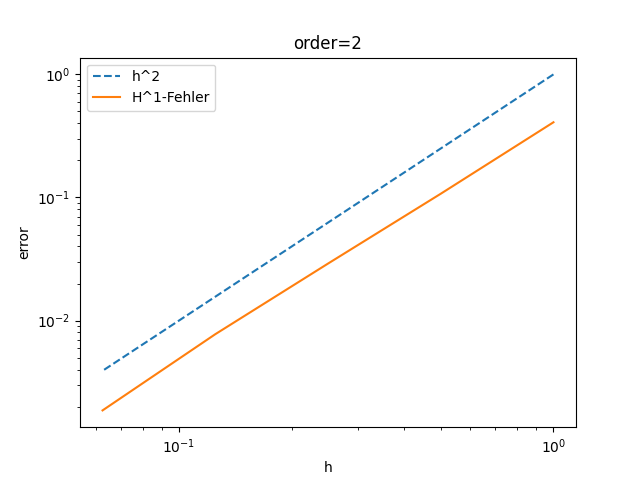

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

order = 2
h_array = np.array([2**-i for i in range(5)])
error_array = []

for h in h_array:
    mesh = Mesh(geo.GenerateMesh(maxh=h))
    fes = H1(mesh, order=order)# fe space
    sol = GridFunction(fes)  # solution
    u = fes.TrialFunction()  # symbolic object
    v = fes.TestFunction()   # symbolic object

    a = BilinearForm(fes, symmetric=True)
    a += (grad(u)*grad(v) + u*v)*dx
    a.Assemble()

    f = LinearForm(fes)
    f += rhs*v*dx
    f.Assemble()
    t1 = time()
    sol.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
    print("time = ", time()-t1)
    error_array.append(sqrt( Integrate((ref_sol-sol)**2 + InnerProduct(ref_sol_grad-Grad(sol),ref_sol_grad-Grad(sol)), mesh, VOL, 2*order) ))


print(error_array)
plt.plot(h_array, h_array**order, linestyle='dashed', label = f"h^{order}")
plt.plot(h_array, error_array, label = "H^1-Fehler")

plt.yscale('log')
plt.xscale('log')
plt.xlabel("h")
plt.ylabel("error")
plt.title(f"order={order}")
plt.legend()
plt.show()

#### 9. Draw error plot - fixes Mesh


time =  0.10347628593444824
time =  0.5265138149261475
time =  1.335869312286377
time =  2.6630773544311523
time =  4.267326831817627
[0.12616070202298613, 0.00483860910014899, 0.00013726977152847883, 3.624331309997243e-06, 7.979682535879503e-08]


<IPython.core.display.Javascript object>


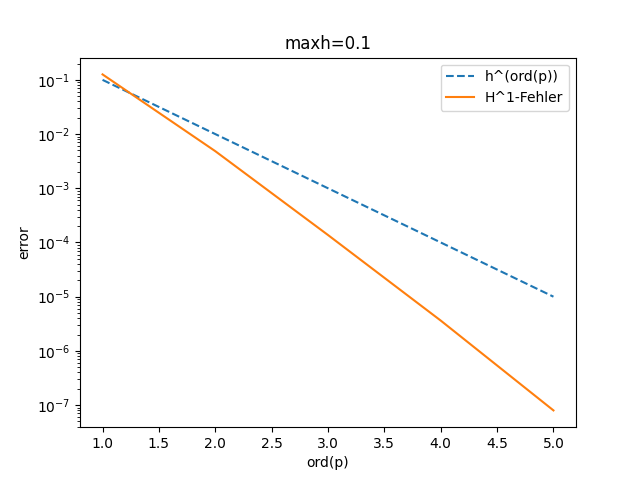

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

maxh = 0.1
mesh = Mesh(geo.GenerateMesh(maxh=maxh))
order_array = [x for x in range(1,6)]
error_array = []

for order in order_array:
    
    fes = H1(mesh, order=order)# fe space
    sol = GridFunction(fes)  # solution
    u = fes.TrialFunction()  # symbolic object
    v = fes.TestFunction()   # symbolic object

    a = BilinearForm(fes, symmetric=True)
    a += (grad(u)*grad(v) + u*v)*dx
    a.Assemble()

    f = LinearForm(fes)
    f += rhs*v*dx
    f.Assemble()
    t1 = time()
    sol.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
    print("time = ", time()-t1)
    error_array.append(sqrt( Integrate((ref_sol-sol)**2 + InnerProduct(ref_sol_grad-Grad(sol),ref_sol_grad-Grad(sol)), mesh, VOL, 2*order) ))


print(error_array)
plt.plot(order_array, [maxh**(x) for x in order_array], linestyle='dashed', label = "h^(ord(p))")
plt.plot(order_array, error_array, label = "H^1-Fehler")

plt.yscale('log')
plt.xlabel("ord(p)")
plt.ylabel("error")
plt.legend()
plt.title(f"maxh={maxh}")
plt.show()